<a href="https://colab.research.google.com/github/Dantedanger/NeuralNetworks/blob/main/gym_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827625 sha256=5591dee49f407da3ad027f1dbeadcf97a9a6cd40d767a71a5b429100b8ac93cc
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [ ]:
import gym

import matplotlib.pyplot as plt
import numpy as np
import random

from collections import deque
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

In [ ]:
render = True
show_model = True

In [ ]:
class Q_model():
    def __init__(self, observation_space, action_space):
        self.state_dim = observation_space
        self.action_dim = action_space
        self.history = deque(maxlen = 2000) # Тип collections.deque
        self.alpha = 200 # Скорость обучения функции ценности состояний
        self.gamma = 0.95 # Коэффициент уменьшения вознаграждения агента
        self.eps = 1.0 # Начальная вероятность случайного действия
        self.epsilon_decay = 0.999 # Коэффициент уменьшения eps на каждом шаге обучения
        self.epsilon_min = 0.005 # Минимальное значение eps
        self.learning_rate = 0.01 # Скорость обучения НС
        self.model = self.build_model() # Создаем модель НС
# Создает модель НС
    def build_model(self):
        inp = Input(self.state_dim)
        x = Dense(128, activation = 'relu')(inp)
        x = Dense(32, activation = 'relu')(x)
        out = Dense(3, activation = 'linear')(x)
        model = Model(inp, out)
        if show_model: model.summary()
        model.compile(loss = 'mse', optimizer = 'Adam')
        return model

    def find_action(self, state): # Случайный выбор действия a (0, 1 или 2)
        if np.random.rand() < self.eps: # Исследование
            a = random.randrange(self.action_dim)
        else: # Выбор действия согласно прогнозу НС
            Q = self.model.predict(state)
            a = np.argmax(Q) # Выбираем наиболее ценное действие
        return a

    def replay(self, batch_size, steps, maxsteps, truncated):
        if len(self.history) < batch_size: return # Случай короткой истории
        # Обучение агента после каждого шага
        # Случайная выборка (без повторов) batch_size элементов истории
        minibatch = random.sample(self.history, batch_size)
        states = np.array([d[0] for d in minibatch])
        next_states = np.array([d[3] for d in minibatch])

        Q = self.model.predict(states)
        #Q1 = self.model.predict(next_states)
        # Формируем Q - цель обучения
        for i, (state, a, reward, new_state, _) in enumerate(minibatch):
            if (steps>=maxsteps or truncated):
                Q[i, a] = reward
            else:
                q = Q[i, a]
                #q1 = np.amax(Q1[i])
                #print(q1,q)
                Q[i, a] = reward + self.alpha * (self.gamma * abs(new_state[1]) - abs(state[1]))
        self.model.train_on_batch(states, Q) # Обучение агента
        self.model.fit(states, Q, verbose = 0) # Обучение агента
        if self.eps > self.epsilon_min: # Уменьшаем вероятность выбора случайного действия
            self.eps *= self.epsilon_decay

In [ ]:
if __name__ == "__main__":
    env = gym.make('MountainCar-v0', render_mode="rgb_array") # Создаем среду
    observation_space = env.observation_space.shape[0] # 2
    action_space = env.action_space.n # 3
    # Q-нейронная сеть
    q_agent = Q_model(observation_space, action_space) # Создаем агента
    episodes = 10 # Число игр
    batch_size = 8
    # Начинаем игру
    # Цель - подняться на гор
    for ep in range(episodes):
        # Получаем начальное состояние объекта перед началом каждой игры (каждого эпизода)
        state = env.reset()
        state = np.reshape(state[0], [1, observation_space])
        # state[0] - позиция тележки
        # state[1] - скорость тележки
        steps = 0
        maxsteps = 200
        modeDone = False
        terminated = False
        truncated  = False
        # Начинаем игру
        # Цель - как можно дольше не допустить падения шеста
        while steps<maxsteps:
            if render: env.render() # Графическое отображение симуляции
            steps += 1
            state = state.reshape(-1, observation_space)
            action = q_agent.find_action(state) # Определяем очередное действие - 0,1,2
            # Получаем от среды, в которой выполнено действие action, состояние объекта, награду и значение флага завершения игры
            # В каждый момент игры, пока не наступило одно из условий ее прекращения, награда равна 1
            state_next, reward, terminated, truncated, info = env.step(action)
            if (steps>=maxsteps or truncated):
              reward = -reward
            if terminated:
                print ("Машина заехала")
                modeDone = True
                break
            # Запоминаем предыдущее состояние объекта, действие, награду за это действие, текущее состояние и значение done
            q_agent.history.append((state[0], action, reward, state_next, terminated))
            state = state_next # Обновляем текущее состояние
            #
            q_agent.replay(batch_size,steps,maxsteps,truncated) # Обучение агента после каждого шага
        print('Эпизод: %d число шагов: %d eps: %.3f' % (ep, steps, q_agent.eps))
        if modeDone:
          break
        # done становится равным True, когда завершается игра,

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 4611 (18.01 KB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 29ms/step
Эпизод: 0 число шагов: 200 eps: 0.824
1/1 [==============================] - 0s 19ms/step
Эпизод: 1 число ш

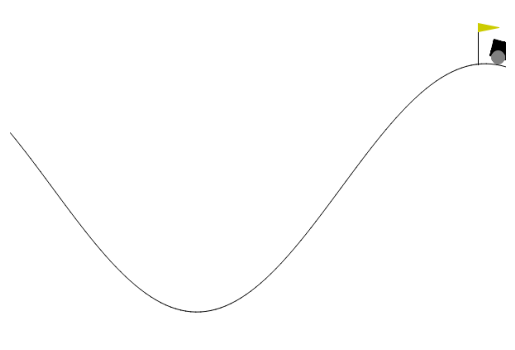

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
img_plot = ax.imshow(env.render())
plt.axis('off')
env.reset()
def update(frame):
    env.step(q_agent.history[len(q_agent.history)-2-frame][1])
    img_plot.set_array(env.render())
    return img_plot,

num_frames = steps
plt.rcParams['animation.embed_limit'] = 2**128
animation = FuncAnimation(fig, update, frames=num_frames, blit=True)
HTML(animation.to_jshtml())